# Project 4: Restaurant Revenue Prediction Analysis

### Problem Statement

This project aims to predict revenue on quick restaurant services in Europe and Asia.

Our company was hired by TFI to develop a model that will predict revenue to help in deciding where to build new restaurants.

For this project, we will first create a linear regression model with use of regularization tools such as LASSO and Ridge to look into the hyper-parameters and parameters. We will run a random forest regressor, KNN regressor, decision tree regressor, bagging regressor, adaboot regressor, and support vector regression. From there, we will choose the best model and utilize a pipeline and gridsearch and compare the scores to the original model.
Success metrics will be evaluated based on the root mean squared error.

### Contents:
- [Background](#Background)
- [Data Import & Cleaning](#Data-Import-and-Cleaning)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing and Modeling](#Preprocessing-and-Modeling)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

### Background

"With over 1,200 quick service restaurants across the globe, TFI is the company behind some of the world's most well-known brands: Burger King, Sbarro, Popeyes, Usta Donerci, and Arby’s. They employ over 20,000 people in Europe and Asia and make significant daily investments in developing new restaurant sites.

Right now, deciding when and where to open new restaurants is largely a subjective process based on the personal judgement and experience of development teams. This subjective data is difficult to accurately extrapolate across geographies and cultures. 

New restaurant sites take large investments of time and capital to get up and running. When the wrong location for a restaurant brand is chosen, the site closes within 18 months and operating losses are incurred [`source`](https://www.kaggle.com/c/restaurant-revenue-prediction/overview)."

### Data used:

The dataset we will be using is from [`data.world`](https://www.kaggle.com/c/restaurant-revenue-prediction/overview).
- [`train.csv`](../datasets/train.csv): Training Dataset
- [`test.csv`](../datasets/test.csv): Testing Dataset

### Data Import & Cleaning

In [2]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, cross_val_score,KFold, GridSearchCV
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, Ridge
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor,BaggingRegressor, AdaBoostRegressor, RandomForestClassifier,BaggingClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR

In [3]:
# Read in Train Dataset
train_path = "../datasets/train.csv"
restaurant_df = pd.read_csv(train_path)

In [146]:
# Read in Test Dataset
test_path = "../datasets/test.csv"
test_df = pd.read_csv(test_path)

In [4]:
# First 5 Rows
restaurant_df.head()

,Id,Open Date,City,City Group,Type,P1,P2,P3,P4,P5,...,P29,P30,P31,P32,P33,P34,P35,P36,P37,revenue
0,0,07/17/1999,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,...,3.0,5,3,4,5,5,4,3,4,5653753.0
1,1,02/14/2008,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,...,3.0,0,0,0,0,0,0,0,0,6923131.0
2,2,03/09/2013,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,...,3.0,0,0,0,0,0,0,0,0,2055379.0
3,3,02/02/2012,Tokat,Other,IL,6,4.5,6.0,6.0,4,...,7.5,25,12,10,6,18,12,12,6,2675511.0
4,4,05/09/2009,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,...,3.0,5,1,3,2,3,4,3,3,4316715.0


In [5]:
# Set `Id` as Index
restaurant_df.set_index('Id', inplace = True)

In [6]:
# Check for Missing Values
restaurant_df.isnull().sum()

Open Date     0
City          0
City Group    0
Type          0
P1            0
P2            0
P3            0
P4            0
P5            0
P6            0
P7            0
P8            0
P9            0
P10           0
P11           0
P12           0
P13           0
P14           0
P15           0
P16           0
P17           0
P18           0
P19           0
P20           0
P21           0
P22           0
P23           0
P24           0
P25           0
P26           0
P27           0
P28           0
P29           0
P30           0
P31           0
P32           0
P33           0
P34           0
P35           0
P36           0
P37           0
revenue       0
dtype: int64

Utilizing .isnull(), there does not seem to be any missing values.

In [159]:
# Lowercase Column Names
restaurant_df.columns = map(str.lower, restaurant_df.columns)
test_df.columns = map(str.lower, test_df.columns)

In [160]:
# Rename columns
restaurant_df = restaurant_df.rename(columns={'open date':'open_date', 'city group':'city_group'})
test_df = test_df.rename(columns={'open date':'open_date', 'city group':'city_group'})

In [9]:
# Data Types
restaurant_df.dtypes

open_date      object
city           object
city_group     object
type           object
p1              int64
p2            float64
p3            float64
p4            float64
p5              int64
p6              int64
p7              int64
p8              int64
p9              int64
p10             int64
p11             int64
p12             int64
p13           float64
p14             int64
p15             int64
p16             int64
p17             int64
p18             int64
p19             int64
p20             int64
p21             int64
p22             int64
p23             int64
p24             int64
p25             int64
p26           float64
p27           float64
p28           float64
p29           float64
p30             int64
p31             int64
p32             int64
p33             int64
p34             int64
p35             int64
p36             int64
p37             int64
revenue       float64
dtype: object

Looking at the data types, we will change `open_date` to DateTime and utilize only the year.

In [162]:
# `open_date` to DateTime
restaurant_df['open_date'] = pd.to_datetime(restaurant_df['open_date'])
test_df['open_date'] = pd.to_datetime(test_df['open_date'])

In [163]:
# Create `year` Column
restaurant_df['year'] = pd.DatetimeIndex(restaurant_df['open_date']).year
test_df['year'] = pd.DatetimeIndex(test_df['open_date']).year

In [164]:
# Create `month` Column
restaurant_df['month'] = pd.DatetimeIndex(restaurant_df['open_date']).month
test_df['month'] = pd.DatetimeIndex(test_df['open_date']).month

In [13]:
# Summary Statistics
restaurant_df.describe()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,...,p31,p32,p33,p34,p35,p36,p37,revenue,year,month
count,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,...,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,137.000000,1.370000e+02,137.000000,137.000000
mean,4.014599,4.408759,4.317518,4.372263,2.007299,3.357664,5.423358,5.153285,5.445255,5.489051,...,1.941606,2.525547,1.138686,2.489051,2.029197,2.211679,1.116788,4.453533e+06,2008.678832,7.058394
std,2.910391,1.514900,1.032337,1.016462,1.209620,2.134235,2.296809,1.858567,1.834793,1.847561,...,3.512093,5.230117,1.698540,5.165093,3.436272,4.168211,1.790768,2.576072e+06,4.027359,3.590769
min,1.000000,1.000000,0.000000,3.000000,1.000000,1.000000,1.000000,1.000000,4.000000,4.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.149870e+06,1996.000000,1.000000
25%,2.000000,4.000000,4.000000,4.000000,1.000000,2.000000,5.000000,4.000000,4.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.999068e+06,2007.000000,4.000000
50%,3.000000,5.000000,4.000000,4.000000,2.000000,3.000000,5.000000,5.000000,5.000000,5.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.939804e+06,2010.000000,8.000000
75%,4.000000,5.000000,5.000000,5.000000,2.000000,4.000000,5.000000,5.000000,5.000000,5.000000,...,3.000000,3.000000,2.000000,3.000000,4.000000,3.000000,2.000000,5.166635e+06,2011.000000,10.000000
max,12.000000,7.500000,7.500000,7.500000,8.000000,10.000000,10.000000,10.000000,10.000000,10.000000,...,15.000000,25.000000,6.000000,24.000000,15.000000,20.000000,8.000000,1.969694e+07,2014.000000,12.000000


Looking at the summary statistics, it is interesting to note that there are many features where the minimum value is 0. Due to hidden demographic, commerical, and real estate data, it will be hard to determine if the 0's are significant, but we will look into correlation of each `p` numbered features to gather insight into the significance of revenue versus the feature.

In [14]:
# Shape of Array
restaurant_df.shape

(137, 44)

The train dataset has 137 rows and 43 columns.

In [15]:
restaurant_df['city_group'].value_counts()

Big Cities    78
Other         59
Name: city_group, dtype: int64

There are two groups that cities fall under, either "Big Cities" or "Other"

In [16]:
restaurant_df['city'].value_counts()

İstanbul          50
Ankara            19
İzmir              9
Bursa              5
Samsun             5
Sakarya            4
Antalya            4
Eskişehir          3
Adana              3
Kayseri            3
Diyarbakır         3
Tekirdağ           3
Trabzon            2
Aydın              2
Muğla              2
Konya              2
Isparta            1
Kocaeli            1
Karabük            1
Kastamonu          1
Gaziantep          1
Kütahya            1
Osmaniye           1
Elazığ             1
Şanlıurfa          1
Tokat              1
Bolu               1
Balıkesir          1
Denizli            1
Afyonkarahisar     1
Kırklareli         1
Edirne             1
Uşak               1
Amasya             1
Name: city, dtype: int64

Looking closer at each city by looking at their value counts, it seems as though "Big Cities" include İstanbul, Ankara, and İzmir while the "Other" group is every other city listed.

In [17]:
restaurant_df['type'].value_counts()

FC    76
IL    60
DT     1
Name: type, dtype: int64

Most restaurants fall under Food Court (FC) and Inline (IL). There is only one Drive Thru (DT) restaurant in this dataset and no Mobile (MB).

### Exploratory Data Analysis

In [18]:
# Correlation of Revenue
rest_df_corr = restaurant_df.corr()[['revenue']].sort_values(by='revenue', ascending=True)

In [19]:
# Helper Function Heat Map
def create_heatmap(corr, title=''):
    plt.figure(figsize=(8, 12))
    sns.set(font_scale=1)
    heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True, cmap='GnBu_r')
    heatmap.set_title(title)

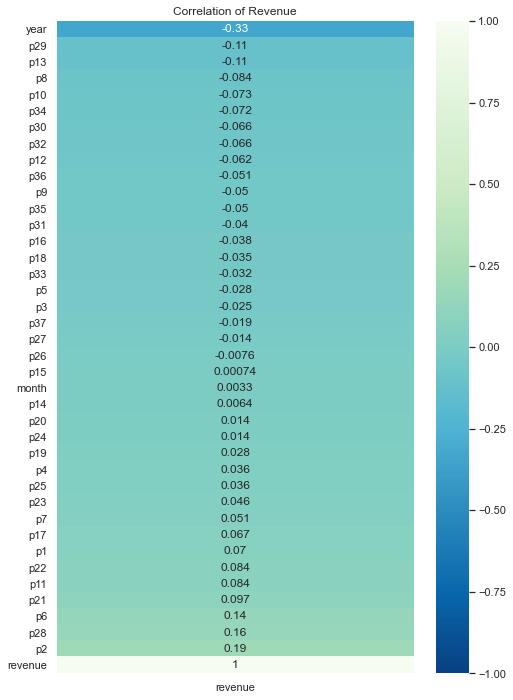

In [20]:
create_heatmap(rest_df_corr, 'Correlation of Revenue')

There are no strong positive or negative correlations of any single feature with revenue.  
But, `year`, `p29`, and `p13` have the highest negative correlation and 
`p2`, `p28`, and `p6` have the highest positive correlation with revenue.

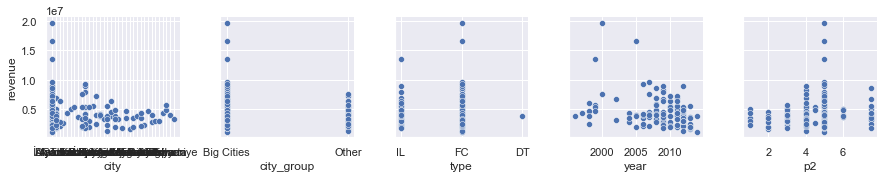

In [21]:
sns.pairplot(data = restaurant_df, y_vars = ['revenue'], x_vars = ['city','city_group','type','year','p2']);

Looking at `city`, `city_group`, `type`, and `year` against revenue, we see clustering to the left and 3 prominent outliers for the city plot. These 3 outliers are shown in the city_group as Big Cities. There doesn't seem to be a linear relationship with regard to year.

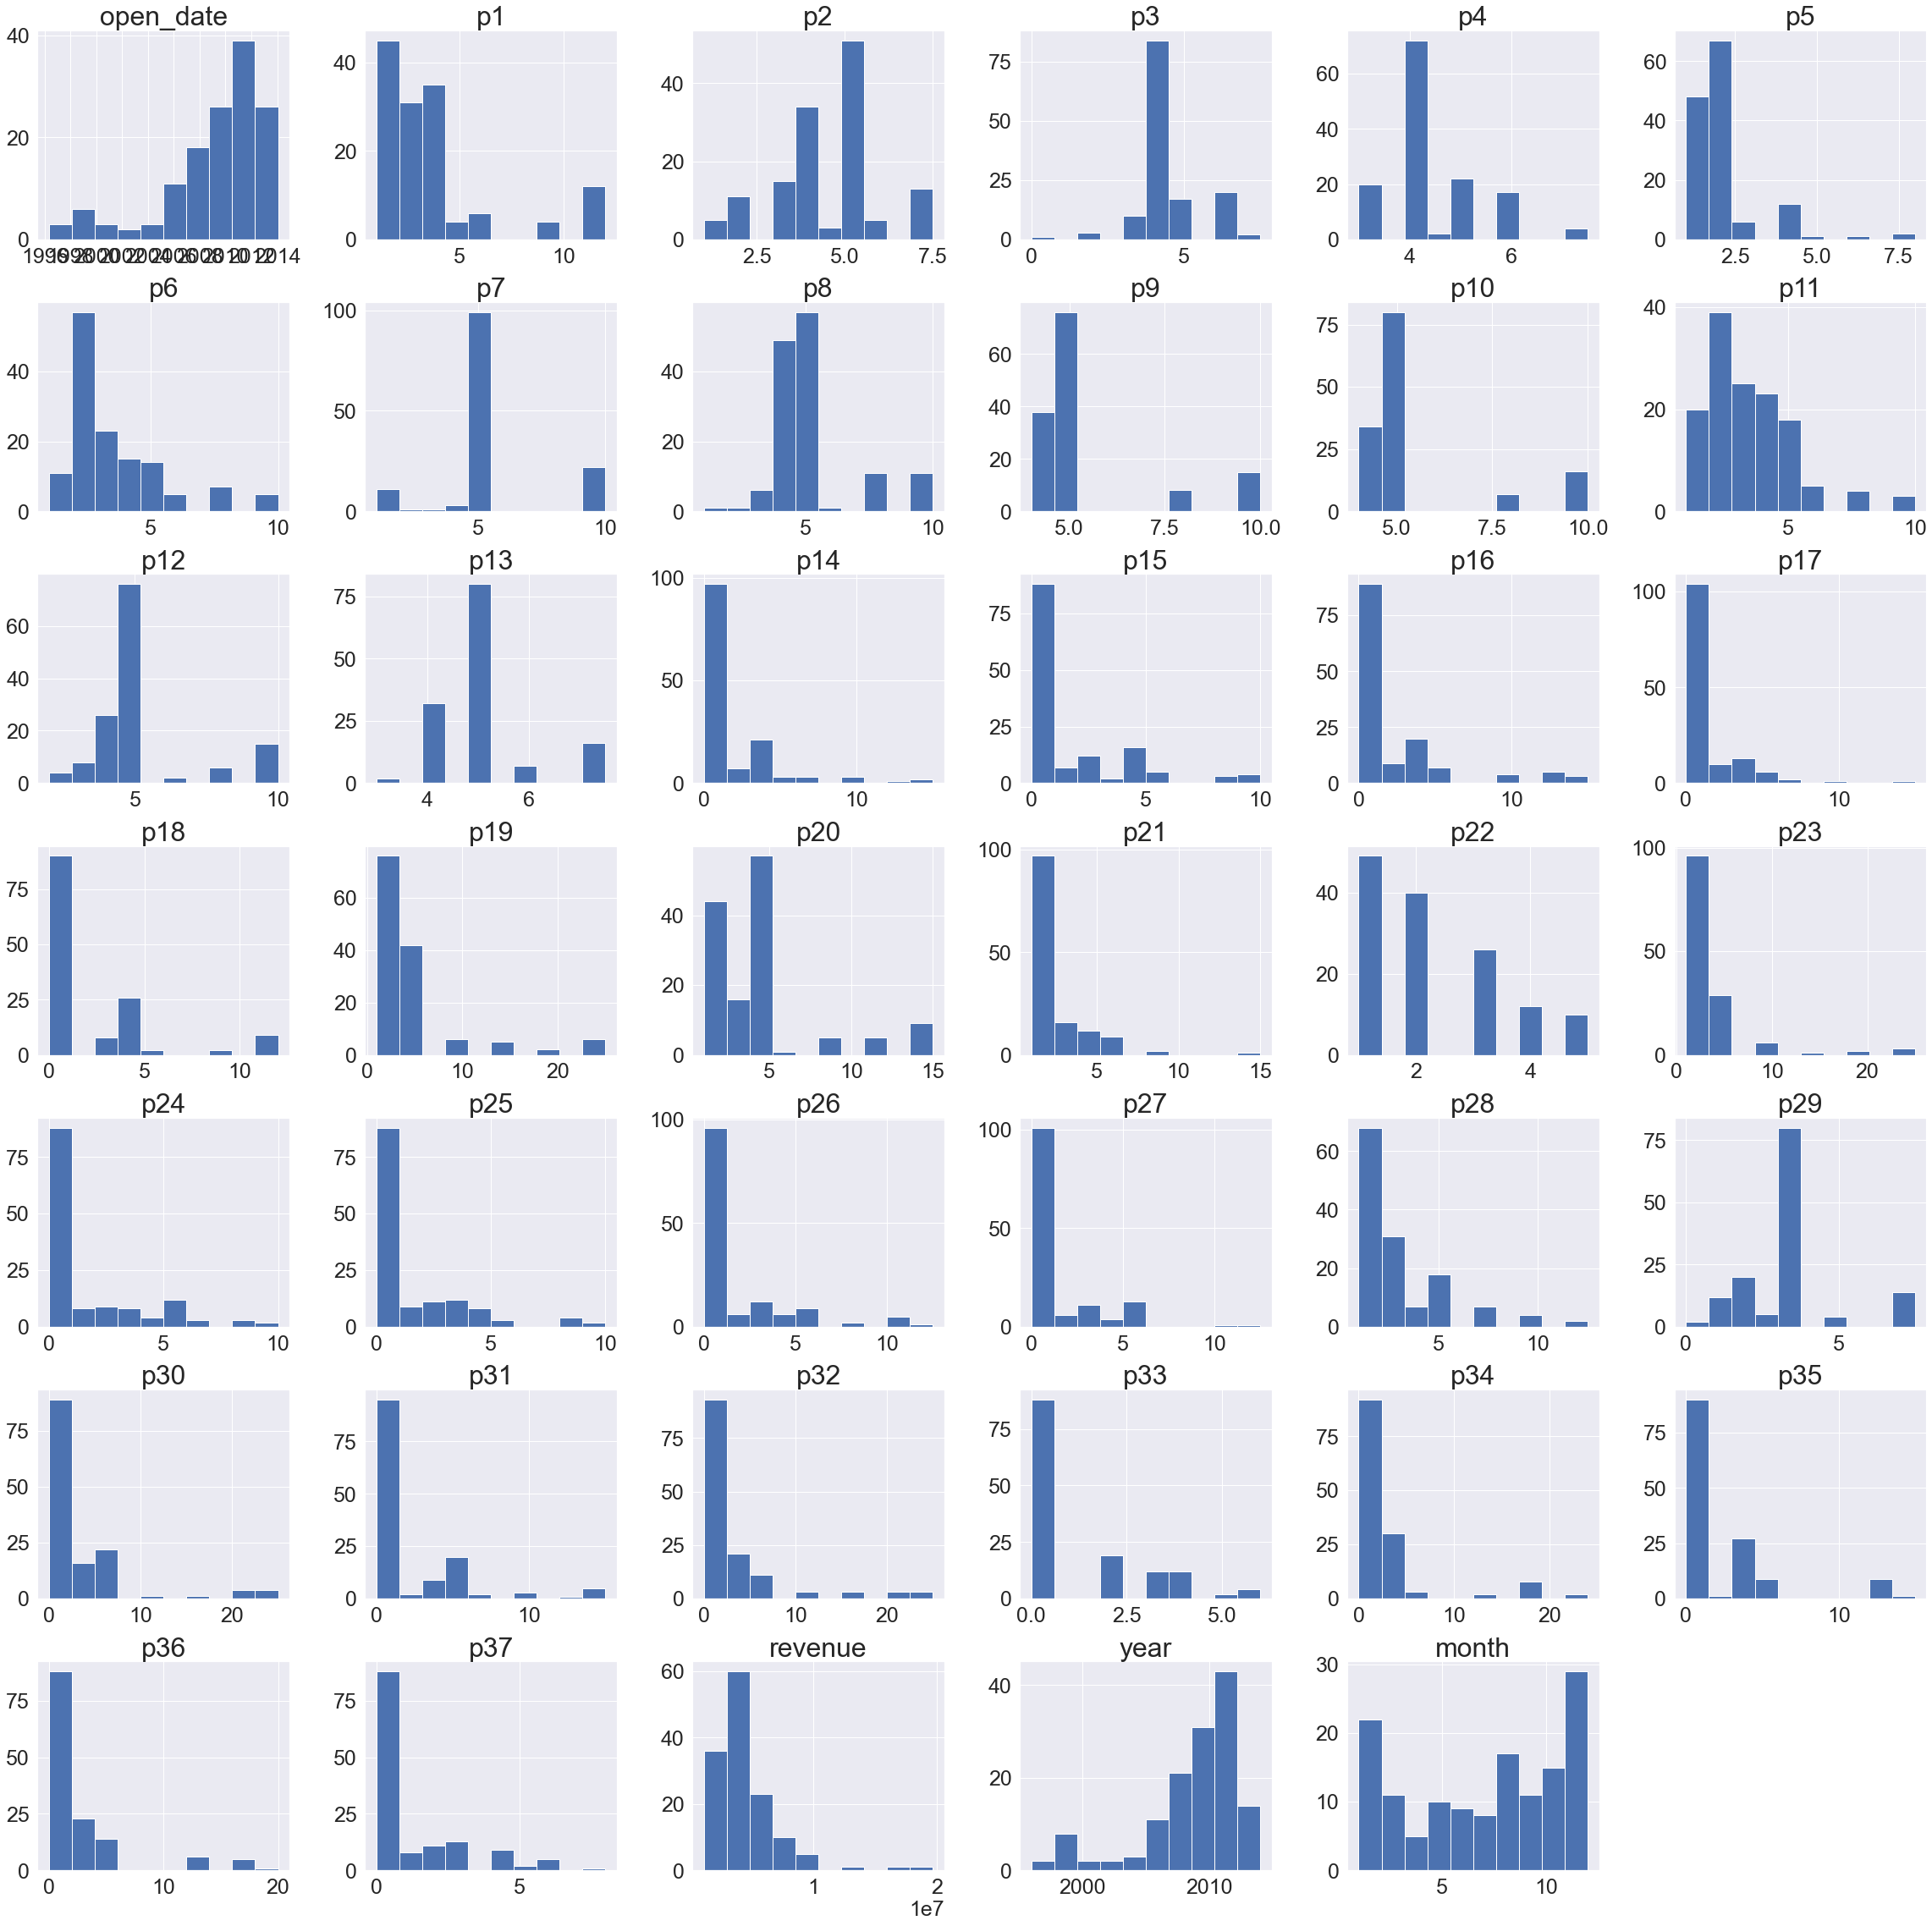

In [22]:
# Plot Histograms for Numerical Features 
params = {'axes.titlesize':'32',
          'xtick.labelsize':'25',
          'ytick.labelsize':'25'}
plt.rcParams.update(params)
restaurant_df.hist(figsize=(40,40));

Looking at the top 3 positive correlation with revenue, we saw `p2` is closest to a normal distribution, while `p6` and `p28` are skewed towards right. Looking at the top 2 negative correlations, `p13` and `p29` seem to be heavily centered around the median.

#### Looking into `year`

In [23]:
# Helper Function to Create Count Plots
def create_countplot(x_var, rotation_degree, title=''):
    fig, ax = plt.subplots(figsize = (10,6))
    plt.title(title, fontsize=15)
    plt.xticks(rotation=rotation_degree, fontsize=15)
    sns.countplot(x_var, ax=ax, palette='BuGn');

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


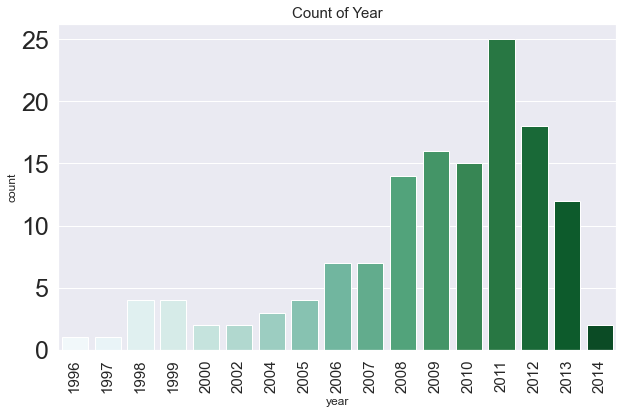

In [24]:
create_countplot(restaurant_df['year'], 90, 'Count of Year')

Looking at the above bar plot, as the years increase, there are more restaurants opening up until 2011. There is a sharp drop in restaurant count towards 2014, which we will need to look further into.

In [25]:
restaurant_df['year'].describe()

count     137.000000
mean     2008.678832
std         4.027359
min      1996.000000
25%      2007.000000
50%      2010.000000
75%      2011.000000
max      2014.000000
Name: year, dtype: float64

In [26]:
restaurant_df[restaurant_df['year']==2014]

,open_date,city,city_group,type,p1,p2,p3,p4,p5,p6,...,p31,p32,p33,p34,p35,p36,p37,revenue,year,month
Id,,,,,,,,,,,,,,,,,,,,,
21,2014-01-25,İstanbul,Big Cities,FC,5,5.0,4.0,4.0,2,2,...,0,0,0,0,0,0,0,1149870.0,2014,1
119,2014-01-03,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,3,...,0,0,0,0,0,0,0,3780019.0,2014,1


Because there is a skewness to the left of the count of year, we will create a feature that groups the years into "older" and "newer" restaurant categories. We will group "older" if it is under 75% of the data (below year 2011) and "newer" if it is over 75% (year 2011 and above).

In [165]:
# New Column `older_restaurant`
restaurant_df['older_restaurant'] = restaurant_df['year'] < 2011

# Boolean Values to 1's and 0's
restaurant_df['older_restaurant'] = restaurant_df['older_restaurant'].astype(int)

# New Column `older_restaurant`
test_df['older_restaurant'] = test_df['year'] < 2011

# Boolean Values to 1's and 0's
test_df['older_restaurant'] = test_df['older_restaurant'].astype(int)

In [28]:
restaurant_df.head()

,open_date,city,city_group,type,p1,p2,p3,p4,p5,p6,...,p32,p33,p34,p35,p36,p37,revenue,year,month,older_restaurant
Id,,,,,,,,,,,,,,,,,,,,,
0,1999-07-17,İstanbul,Big Cities,IL,4,5.0,4.0,4.0,2,2,...,4,5,5,4,3,4,5653753.0,1999,7,1
1,2008-02-14,Ankara,Big Cities,FC,4,5.0,4.0,4.0,1,2,...,0,0,0,0,0,0,6923131.0,2008,2,1
2,2013-03-09,Diyarbakır,Other,IL,2,4.0,2.0,5.0,2,3,...,0,0,0,0,0,0,2055379.0,2013,3,0
3,2012-02-02,Tokat,Other,IL,6,4.5,6.0,6.0,4,4,...,10,6,18,12,12,6,2675511.0,2012,2,0
4,2009-05-09,Gaziantep,Other,IL,3,4.0,3.0,4.0,2,2,...,3,2,3,4,3,3,4316715.0,2009,5,1


We created binary variables where:
- 0 = If the restaurant was opened after 2011
- 1 = If the restaurant was opened before 2011

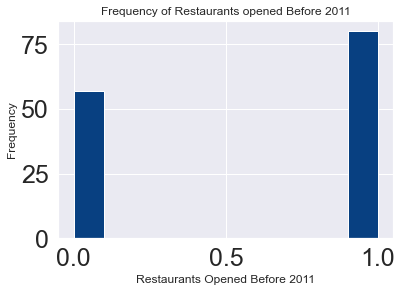

In [29]:
# Histogram of `older_restaurant`
restaurant_df['older_restaurant'].plot(kind='hist', cmap='GnBu_r')
plt.title('Frequency of Restaurants opened Before 2011', fontsize=12)
plt.xlabel('Restaurants Opened Before 2011');

Looking at the above histogram, there is now a more even distribution between the year of restaurant opening date when compared to the count plot for year.

#### Looking into `month`

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


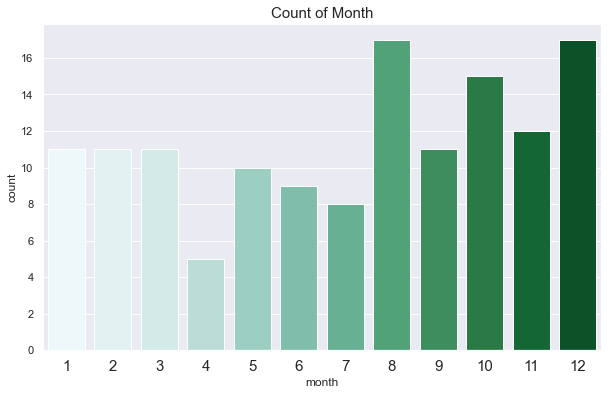

In [93]:
create_countplot(restaurant_df['month'], 0, 'Count of Month')

After looking into year, we decided to take the `open_date` feature and make a new column for the month. There seems to be more restaurants opening in August and January and less in April and July.

#### Looking into `type`

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


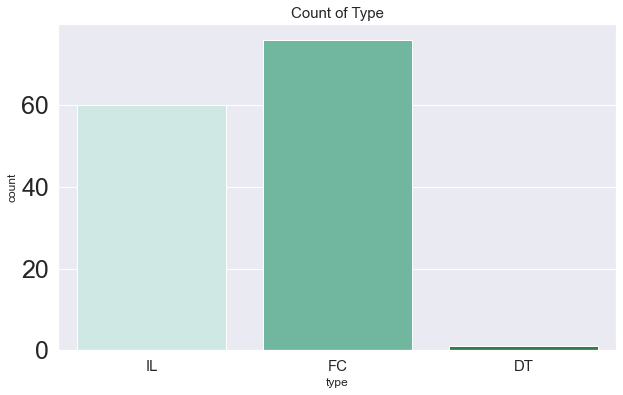

In [31]:
create_countplot(restaurant_df['type'], 0, 'Count of Type')

The above count plot represents the count of `type` in the training set. Most restaurants fall under Food Court (FC) and Inline (IL). There is only one Drive Thru (DT) restaurant in this dataset and no Mobile (MB). Because DT and MB are not very apparent in this dataset, this could pose a potential problem when running a model on the test set.

In [169]:
# Mapping `type` into Numerical Columns
restaurant_df['type_numerical'] = restaurant_df['type'].map({'FC':0, 'IL':1, 'DT':2, 'MB':3})
test_df['type_numerical'] = test_df['type'].map({'FC':0, 'IL':1, 'DT':2, 'MB':3})

We created numerical variables where:
- 0 = FC (Food Court)
- 1 = IL (Inline)
- 2 = DT (Drive Thru)
- 3 = MB (Mobile)

#### Looking into `city`

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


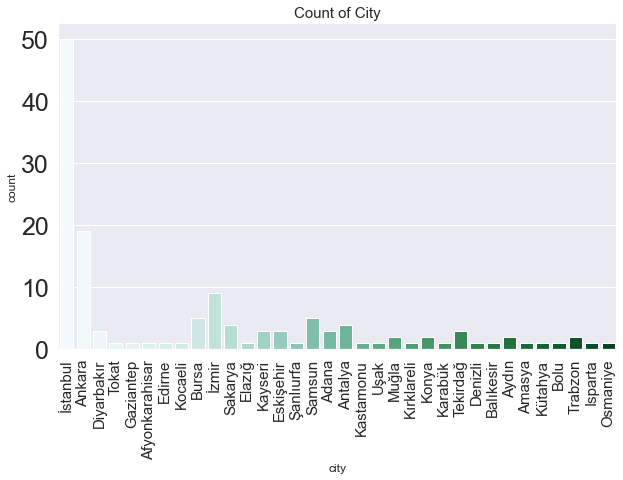

In [33]:
create_countplot(restaurant_df['city'], 90, 'Count of City')

After plotting `city`, we see that there are many cities with small values. We will utilize `city_group` in our model instead of `city` so that there isn't as big as an imbalance.

#### Looking into `city_group`

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


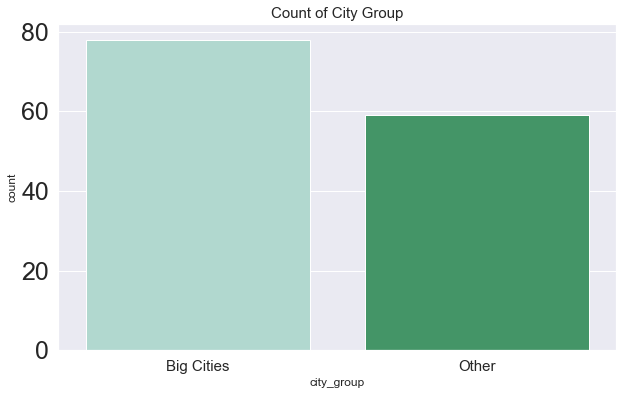

In [34]:
create_countplot(restaurant_df['city_group'], 0, 'Count of City Group')

Because the 2 city groups are somewhat evenly distributed, we will map the groups into binary columns to utilize in our modeling.

In [166]:
# Mapping `city_group` into Binary Columns
restaurant_df['city_group_binary'] = restaurant_df['city_group'].map({'Big Cities':0, 'Other':1})

In [167]:
test_df['city_group_binary'] = test_df['city_group'].map({'Big Cities':0, 'Other':1})

We created binary variables where:
- 0 = Big Cities
- 1 = Other

#### Correlation of Features with Positive and Negative Correlations of Revenue

Because the correlation of features with revenue were not high, we are going to look into the top 3 highest correlated positive and negative features to see if there are any interaction between the variables.

##### Top 3 Positive Correlation with Revenue:

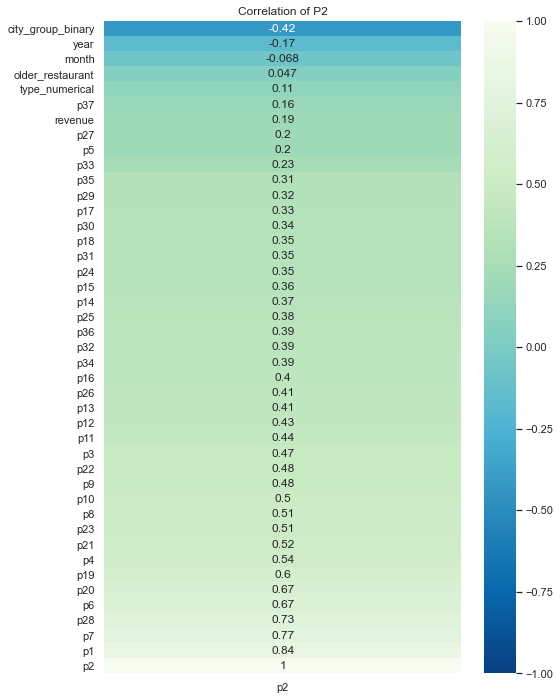

In [37]:
# P2 Correlation
p2_corr = restaurant_df.corr()[['p2']].sort_values(by='p2', ascending=True)
create_heatmap(p2_corr, 'Correlation of P2')

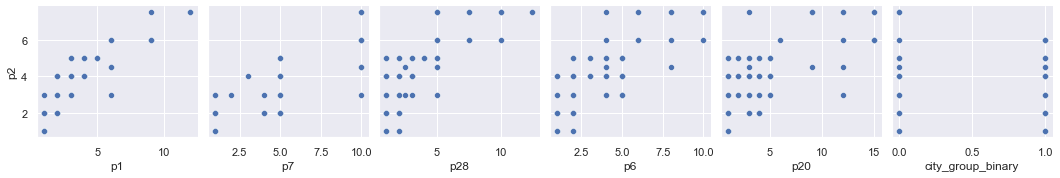

In [38]:
sns.pairplot(data = restaurant_df, y_vars = ['p2'], x_vars = ['p1','p7','p28', 'p6', 'p20', 'city_group_binary']);

Looking at `p2`, there seems to be a linear relationship between the high positive correlation features `p1`, `p7`, `p28`, `p6`, `p20`.

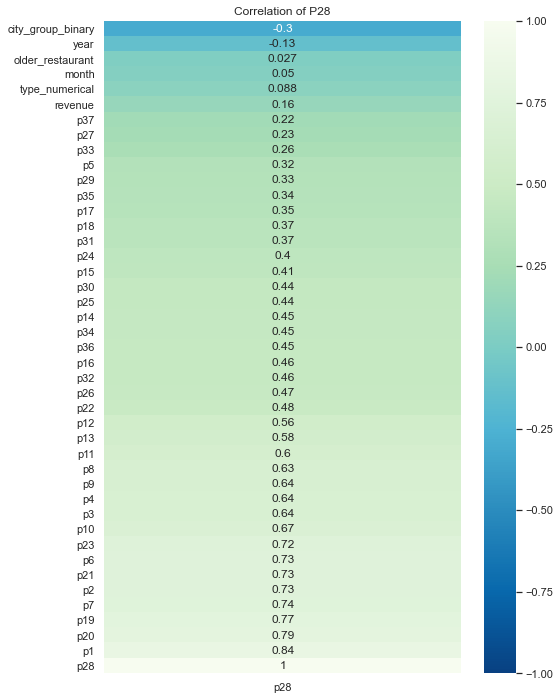

In [39]:
# P28 Correlation
p28_corr = restaurant_df.corr()[['p28']].sort_values(by='p28', ascending=True)
create_heatmap(p28_corr, 'Correlation of P28')

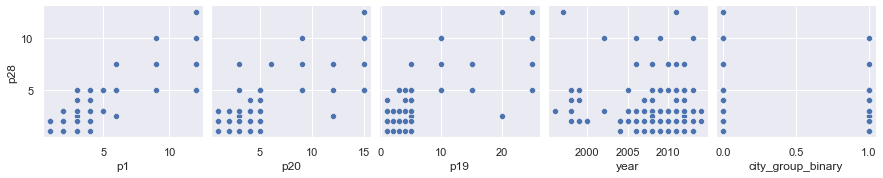

In [187]:
sns.pairplot(data = restaurant_df, y_vars = ['p28'], x_vars = ['p1','p20','p19', 'year', 'city_group_binary']);

When looking at `p28` there seems to be a somewhat linear shape for `p1`, `p20`, and `p19`.

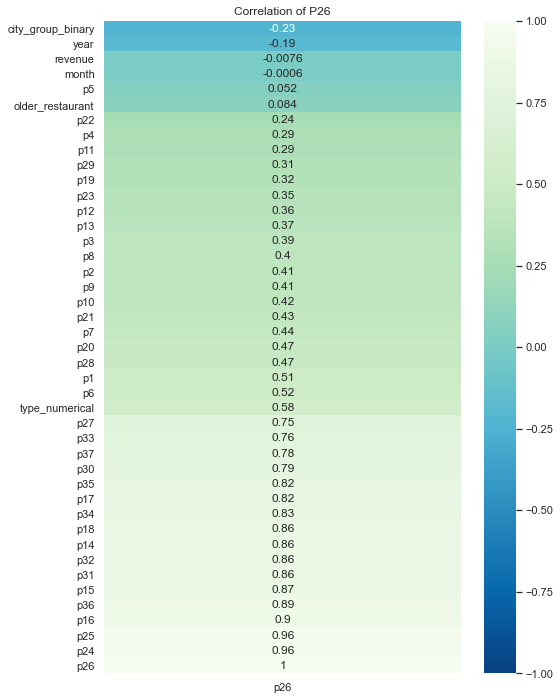

In [40]:
# P26 Correlation
p26_corr = restaurant_df.corr()[['p26']].sort_values(by='p26', ascending=True)
create_heatmap(p26_corr, 'Correlation of P26')

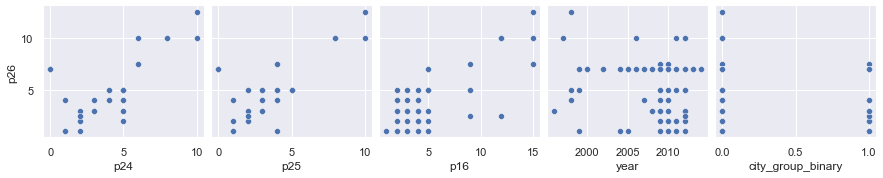

In [188]:
sns.pairplot(data = restaurant_df, y_vars = ['p26'], x_vars = ['p24','p25','p16', 'year', 'city_group_binary']);

When looking at `p26` there seems to be a somewhat linear shape for `p24`, `p25`, and `p16`.

##### Top 3 Negative Correlation with Revenue:

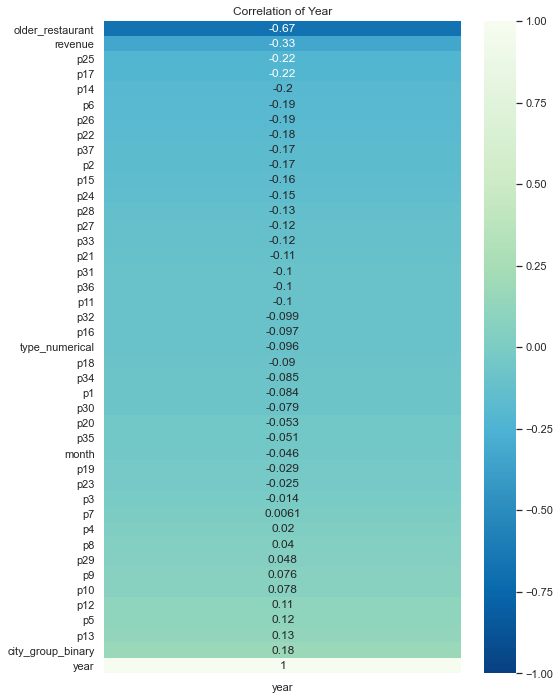

In [41]:
# Year Correlation
year_corr = restaurant_df.corr()[['year']].sort_values(by='year', ascending=True)
create_heatmap(year_corr, "Correlation of Year")

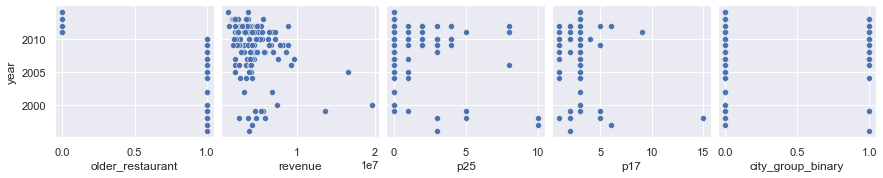

In [189]:
sns.pairplot(data = restaurant_df, y_vars = ['year'], x_vars = ['older_restaurant','revenue','p25', 'p17', 'city_group_binary']);

There does not seem to be any clear relationships within these scatterplots above for feature `year`.

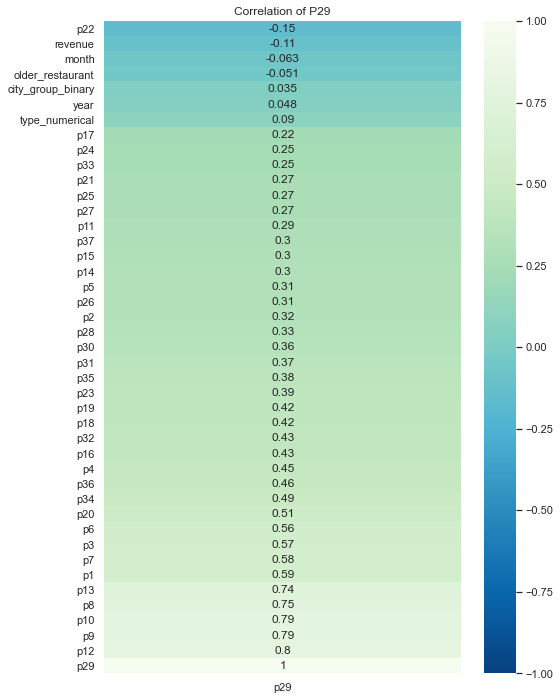

In [42]:
# P29 Correlation
p29_corr = restaurant_df.corr()[['p29']].sort_values(by='p29', ascending=True)
create_heatmap(p29_corr, "Correlation of P29")

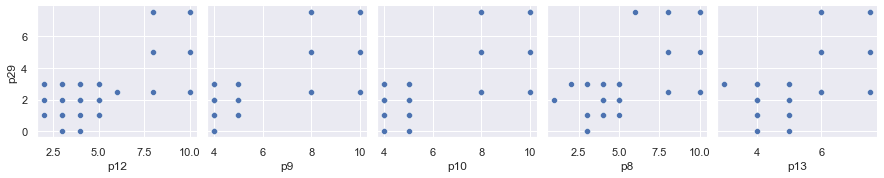

In [190]:
sns.pairplot(data = restaurant_df, y_vars = ['p29'], x_vars = ['p12','p9','p10', 'p8', 'p13']);

There seems to be an upward trend towards these features. By combining some of these features with `p29`, this may potentially make the correlation stronger.

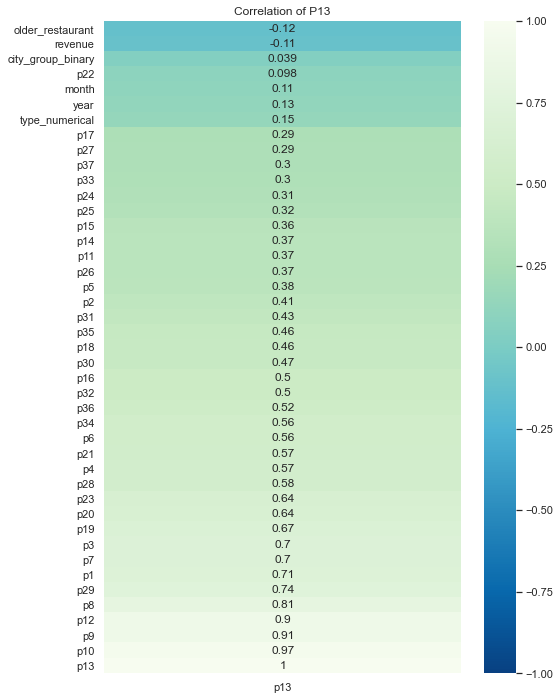

In [43]:
# P13 Correlation
p13_corr = restaurant_df.corr()[['p13']].sort_values(by='p13', ascending=True)
create_heatmap(p13_corr, "Correlation of P13")

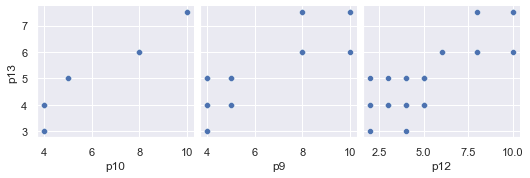

In [191]:
sns.pairplot(data = restaurant_df, y_vars = ['p13'], x_vars = ['p10','p9','p12']);

There seems to be an upward trend towards these features. By combining some of these features with `p13`, this may potentially make the correlation stronger.

### Preprocessing and Modeling

In [134]:
initial_features = ['p1', 'p2', 'p3', 'p4', 'p5',
       'p6', 'p7', 'p8', 'p9', 'p10', 'p11', 'p12', 'p13', 'p14', 'p15', 'p16',
       'p17', 'p18', 'p19', 'p20', 'p21', 'p22', 'p23', 'p24', 'p25', 'p26',
       'p27', 'p28', 'p29', 'p30', 'p31', 'p32', 'p33', 'p34', 'p35', 'p36',
       'p37', 'year', 'month', 'older_restaurant', 'type_numerical',
       'city_group_binary']

In [135]:
# Defining X 
X =restaurant_df[initial_features]

# Defining y
y = restaurant_df['revenue']

In [136]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [137]:
# Pipeline Random Forest
pipe_rf = Pipeline([('ss', StandardScaler()),
('rf', RandomForestRegressor())])

# Pipeline Linear Regression
pipe_lr = Pipeline([('ss', StandardScaler()),
('lr', LinearRegression())])

# Pipeline Ridge
pipe_rr = Pipeline([('ss', StandardScaler()),
('rr', Ridge())])

# Pipeline LASSO
pipe_ls = Pipeline([('ss', StandardScaler()),
('ls', LassoCV())])

# Pipeline KNN
pipe_kn = Pipeline([('ss', StandardScaler()),
('kn', KNeighborsRegressor())])

# Pipeline Decision Tree
pipe_dt = Pipeline([('ss', StandardScaler()),
('dt', DecisionTreeRegressor())])

# Pipeline Bagging
pipe_br = Pipeline([('ss', StandardScaler()),
('br', BaggingRegressor())])

# Pipeline AdaBoot
pipe_ar = Pipeline([('ss', StandardScaler()),
('ar', AdaBoostRegressor())])

# Pipeline SVR
pipe_svr = Pipeline([('ss', StandardScaler()),
('svr', SVR(kernel='linear'))])

In [138]:
# Fit Models
pipe_rf.fit(X_train,y_train);

pipe_lr.fit(X_train,y_train);

pipe_rr.fit(X_train,y_train);

pipe_ls.fit(X_train,y_train);

pipe_kn.fit(X_train,y_train);

pipe_dt.fit(X_train,y_train);

pipe_br.fit(X_train,y_train);

pipe_ar.fit(X_train,y_train);

pipe_svr.fit(X_train,y_train);

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 327647288953.34375, tolerance: 50894447129.05057
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 534504226600.28125, tolerance: 50894447129.05057
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 562749906368.4688, tolerance: 50894447129.05057
  model = cd_fast.enet_coordinate_descent_gram(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: 

In [147]:
# Train and Test RMSE Score
model_list = [pipe_rf,pipe_rr,pipe_kn,pipe_dt,pipe_br,pipe_ar,pipe_svr,pipe_lr,pipe_ls]
for model in model_list:
    print (model[1])
    print (f'RMSE Train: {mean_squared_error(y_train,model.predict(X_train), squared = False)}')
    print (f'RMSE Test: {mean_squared_error(y_test,model.predict(X_test), squared = False)}')
    print ('')

RandomForestRegressor()
RMSE Train: 893585.9745934233
RMSE Test: 3314455.2084415373

Ridge()
RMSE Train: 1648924.8989227903
RMSE Test: 4151521.27560267

KNeighborsRegressor()
RMSE Train: 1746796.7110644386
RMSE Test: 3297919.5150741395

DecisionTreeRegressor()
RMSE Train: 0.0
RMSE Test: 3059431.0150281913

BaggingRegressor()
RMSE Train: 998837.9649072093
RMSE Test: 3545597.384901127

AdaBoostRegressor()
RMSE Train: 1251141.7449099359
RMSE Test: 3420844.054312795

SVR(kernel='linear')
RMSE Train: 2315735.101794888
RMSE Test: 3607781.254271991

LinearRegression()
RMSE Train: 1631141.546471218
RMSE Test: 4326207.709865255

LassoCV()
RMSE Train: 2011305.945096673
RMSE Test: 3516837.0443962617



In [145]:
# Dataframe to show coefficients after running LASSO
coef_df = pd.DataFrame(data = pipe_ls['ls'].coef_, index = X.columns, columns = ['feature'])

coef_df.loc[abs(coef_df['feature'])> 0]

,feature
p17,436210.794308
p21,83479.688455
p28,88360.235419
p30,-189050.690272
p32,-102287.019087
p34,-48294.063604
year,-119929.849009
older_restaurant,239036.094733
city_group_binary,-246486.320687


In [148]:
# imputed 0 values with mean

restaurant_df['p17'] = np.where(restaurant_df['p17'] == 0, 3, restaurant_df['p17'])
restaurant_df['p30'] = np.where(restaurant_df['p30'] == 0, 7.5, restaurant_df['p30'])
restaurant_df['p32'] = np.where(restaurant_df['p32'] == 0, 7, restaurant_df['p32'])
restaurant_df['p26'] = np.where(restaurant_df['p26'] == 0, 7, restaurant_df['p26'])
restaurant_df['p16'] = np.where(restaurant_df['p16'] == 0, 5, restaurant_df['p16'])

In [150]:
# Final Features after Removing LASSO Coefficients
features = ['city_group_binary','year','older_restaurant','type_numerical','p2','p17','p32','p30','p26','p16']

In [151]:
# Defining X 
X =restaurant_df[features]

In [152]:
# Defining y
y = restaurant_df['revenue']

In [153]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [154]:
# Pipeline Random Forest
pipe_rf = Pipeline([('ss', StandardScaler()),
('rf', RandomForestRegressor())])

# Pipeline Linear Regression
pipe_lr = Pipeline([('ss', StandardScaler()),
('lr', LinearRegression())])

# Pipeline Ridge
pipe_rr = Pipeline([('ss', StandardScaler()),
('rr', Ridge())])

# Pipeline LASSO
pipe_ls = Pipeline([('ss', StandardScaler()),
('ls', LassoCV())])

# Pipeline KNN
pipe_kn = Pipeline([('ss', StandardScaler()),
('kn', KNeighborsRegressor())])

# Pipeline Decision Tree
pipe_dt = Pipeline([('ss', StandardScaler()),
('dt', DecisionTreeRegressor())])

# Pipeline Bagging
pipe_br = Pipeline([('ss', StandardScaler()),
('br', BaggingRegressor())])

# Pipeline AdaBoot
pipe_ar = Pipeline([('ss', StandardScaler()),
('ar', AdaBoostRegressor())])

# Pipeline SVR
pipe_svr = Pipeline([('ss', StandardScaler()),
('svr', SVR(kernel='linear'))])

In [155]:
# Fit Models
pipe_rf.fit(X_train,y_train);

pipe_lr.fit(X_train,y_train);

pipe_rr.fit(X_train,y_train);

pipe_ls.fit(X_train,y_train);

pipe_kn.fit(X_train,y_train);

pipe_dt.fit(X_train,y_train);

pipe_br.fit(X_train,y_train);

pipe_ar.fit(X_train,y_train);

pipe_svr.fit(X_train,y_train);

In [156]:
# Train and Test RMSE Score
model_list = [pipe_rf,pipe_rr,pipe_kn,pipe_dt,pipe_br,pipe_ar,pipe_svr,pipe_lr,pipe_ls]
for model in model_list:
    print (model[1])
    print (f'RMSE Train: {mean_squared_error(y_train,model.predict(X_train), squared = False)}')
    print (f'RMSE Test: {mean_squared_error(y_test,model.predict(X_test), squared = False)}')
    print ('')

RandomForestRegressor()
RMSE Train: 1069573.9630900305
RMSE Test: 2838448.910598676

Ridge()
RMSE Train: 1947533.3473267579
RMSE Test: 3660791.2001504265

KNeighborsRegressor()
RMSE Train: 1847649.5784971481
RMSE Test: 3082114.4512906987

DecisionTreeRegressor()
RMSE Train: 723580.2592777916
RMSE Test: 2842746.0712469635

BaggingRegressor()
RMSE Train: 1199281.9393548896
RMSE Test: 2875515.372996042

AdaBoostRegressor()
RMSE Train: 1541875.1328066206
RMSE Test: 3079195.504519141

SVR(kernel='linear')
RMSE Train: 2315671.3186505237
RMSE Test: 3607649.9810546897

LinearRegression()
RMSE Train: 1947471.3170868165
RMSE Test: 3673149.9328147233

LassoCV()
RMSE Train: 1952491.7499035404
RMSE Test: 3627594.312136923



The list above shows the train and test RMSE score for each model that was ran. We found that the best two models were the bagged decision tree and the adaboost regressor. We decided to utilize a gridsearch on those two models to see if we could improve the RMSE by utilizing the hyperparameters from the gridsearch.

In [68]:
print(pipe_ar.score(X_train,y_train))
print(pipe_ar.score(X_test,y_test))

0.4693889711564271
0.46652602564775314


In [102]:
print(pipe_br.score(X_train,y_train))
print(pipe_br.score(X_test,y_test))

0.7299561963163328
0.30824488038143694


### Submission (Test Set)

In [170]:
X_submit = test_df[features]

In [173]:
# Scale, Fit, Transform Test Set
ss = StandardScaler()
X_submit = ss.fit_transform(X_submit)

In [176]:
# Predicted Values
y_predict = pipe_ar.predict(X_submit)
y_predict

array([4055703.77777778, 3940464.28571429, 4824941.63043478, ...,
       4055703.77777778, 4824941.63043478, 4363366.13043478])

In [180]:
test_df['y_pred'] = y_predict

In [185]:
submission = test_df['y_pred']

In [186]:
# Submission to CSV File
submission.to_csv('../datasets/submission.csv', index=True)

### Gridsearch on Bagged Decision Tree & AdaBoost Regressor

In [76]:
# Bagging Regressor Parameters
n_samples = X.shape[0]
n_features = X.shape[1]
params_br = {'br__base_estimator': [None],
          'br__n_estimators': [50,100,150],
          'br__max_samples': [0.5,1.0, n_samples//2],
          'br__max_features': [0.5,1.0, n_features//2],
          'br__bootstrap': [True],
          'br__bootstrap_features': [True]}

In [77]:
# AdaBoost Parameters
params_ar = {
          'ar__n_estimators': [50,100,150,200,300],
          
          'ar__learning_rate': [.001,.01,.1,.2,.5]}

In [78]:
# Gridsearch Bagging Regressor
gs_br = GridSearchCV(pipe_br, 
                  param_grid=params_br,
                  cv=5,
                    n_jobs = -1) 

In [79]:
# Gridsearch AdaBoost Regressor
gs_ar = GridSearchCV(pipe_ar, 
                  param_grid=params_ar,
                  cv=5,
                    n_jobs = -1)

In [81]:
# Fit AdaBoost
gs_ar.fit(X_train,y_train);

In [82]:
# Fit Bagging Regressor
gs_br.fit(X_train,y_train);

In [84]:
# AdaBoost
gs_ar.best_score_

0.04532871808360013

In [85]:
# AdaBoost Train Score
gs_ar.score(X_train,y_train)

0.31876814856613456

In [86]:
# AdaBoost Test Score
gs_ar.score(X_test,y_test)

0.1476188710285118

In [104]:
print (f'AdaBoost RMSE Train: {mean_squared_error(y_train,gs_ar.predict(X_train), squared = False)}')
print (f'AdaBoost RMSE Test: {mean_squared_error(y_test,gs_ar.predict(X_test), squared = False)}')

AdaBoost RMSE Train: 1900172.455279631
AdaBoost RMSE Test: 3292895.1415590495


Comparing the RMSE score, we found that the RMSE was actually better without the gridseach. The RMSE we got for AdaBoost was 1541875 (train) and 3079195 (test).

In [105]:
gs_br.best_params_

{'br__base_estimator': None,
 'br__bootstrap': True,
 'br__bootstrap_features': True,
 'br__max_features': 0.5,
 'br__max_samples': 0.5,
 'br__n_estimators': 150}

In [106]:
print (f'Boosting Regressor RMSE Train: {mean_squared_error(y_train,gs_br.predict(X_train), squared = False)}')
print (f'Boosting Regressor RMSE Test: {mean_squared_error(y_test,gs_br.predict(X_test), squared = False)}')

Boosting Regressor RMSE Train: 1856710.215707012
Boosting Regressor RMSE Test: 3170803.870855401


Comparing the RMSE score, we found that the RMSE was actually better without the gridseach. The RMSE we got for the decision tree boosting regressor was 1199281 (train) and 2815515 (test). The gridsearch results seem to be more overfit.

In [90]:
# Boosting
gs_br.best_score_

0.06740145227064742

In [91]:
# Boosting Train Score
gs_br.score(X_train,y_train)

0.4393001865298721

In [92]:
# Boosting Test Score
gs_br.score(X_test,y_test)

0.1737798285983979

### Conclusions and Recommendations

In conclusion, we first ran a linear regression model with LASSO and removed coefficients that were 0. We also did feature engineering on `p` features that had positive and negative correlation with revenue. Because none of the initial features had high correlation with revenue, we took the top 3 positive and top 3 negative features and ran correlaton tests on them. We then combined the features with highest correlation. In the end, we ended up taking these features out, as it did not improve the model. We also did models on random forest regressor, KNN regressor, decision tree regressor, bagging regressor, adaboost regressor, and support vector regression and found that the best model was adaboost regressor. From all the models that we ran, we found that all models were overfit. This may be due to the imbalance in data and possible outliers that were not removed.

The submission score we got on Kaggle was 1860246.00848 (RMSE). Comparitively, the highest scores on the private leaderboard on Kaggle ranged from around 1700000.

In terms of features that we found important in increasing revenue and building new restaurants, we found that
`city_group_binary` had this highest negative coefficient (-246486.320687) while the highest positive coefficient was `p17` (436210.794308) and `older_restaurant` (239036.094733). For `p17`, for 1 standard deviation increase, the revenue increases by 436210.79.

Potential next steps: 
- Create synthetic data to help with the imbalance in data
- Look further into outliers